# **Waze User Churn: Logistic Regression Modeling**
**This notebook develops and evaluates a binomial logistic regression model to predict user chrun for Waze based on app usage and driver behavior variables. The focus is on translating exploratory data analysis into a predictive model and interpreting model performance and feature effects in a business context.**

The analysis proceeds in three stages:
- Exploratory data analysis (EDA) and assumption checks for logistic regression
- Model building and evaluation using a binomial logistic regression classifier
- Interpretation of model results and implications for churn-focused business decisions

The objective is to build a model that predicts whether a user churns and to understand which behavioral features are most associated with churn. 

### **Data and Libraries**
The Waze churn dataset is loaded into a pandas DataFrame, and standard Python and scikit-learn tools are used for visualizations, feature engineering and logistics regression modeling. 

In [1]:
# Core libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# tools for preprocessing, model training, and evaluation
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

The churn dataset is read from CSV into a DataFrame for analysis. 

In [2]:
df = pd.read_csv('waze_dataset.csv')

## **Exploratory data analysis**

EDA is used to understand class balance, identify missing values, and detect potential outliers or data quality issues that may influence a logistic regression model. Visual inspection of distributions and summary staistics support later decisions on feature engineer, outlier handling, and model assumptions. 

### **Data structure, missing values, and outliers**

The intial EDA examines dataset dimnesions, data types, missing labels, and summary statistics to understand overall structure and detect variables with extreme values. 


In [3]:
print(df.shape)
df.info()

(14999, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [4]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [5]:
# drop the unique identifier not needed for modeling
df = df.drop('ID',axis=1)

In [6]:
# check class balance of the churn label
df['label'].value_counts(normalize='True')

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

In [7]:
# summary staistics for numeric variables
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


The dataset contains 700 missing values in the `label` (target) column, representing less than 5% of observations. 

Several usage-related variables(`sessions`,`drives`,`total_sessions`,`total_navigations_fav1`,`total_navigations_fav2`,`driven_km_drives`,`duration_minutes_drives`) exhibit extreme values, with maxima standard deviations above the upper quartile, indicating potential outliers. 

### **Feature Engineering**

To better capture driving intensity, a new feature `km_per_driving_day` is created as the average distance driven per day for each user. Thsi condenses multiple raw variables into a single measure of driving behavior over the last month. 

In [8]:
# mean distance driven per driving day
df['km_per_driving_day'] = df['driven_km_drives']/df['driving_days']
df['km_per_driving_day'].describe()

/Users/shreyasj/Library/Python/3.9/lib/python/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [9]:
# replace infinite values with zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

A binary `professional_driver` flag is introduced to distinguish heavy users (at least 60 drives and 15 or more driving days in the last month) from other drivers, using domain-informed thresholds.

In [10]:
# `professional_driver` column
df['professional_driver'] = np.where((df['drives']>=60) & (df['driving_days']>=15), 1, 0)

In [11]:
print(df['professional_driver'].value_counts())
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

professional_driver
0    12405
1     2594
Name: count, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

Professional drivers show a churn rate of about 7.6%, compared with roughly 19.9% for non-professional users, indicating that high-activity drivers are substantially more like to be retained and that this feature may add predictive signal to the model. 

## **Model construction strategy**

Predictor selection us guided by the business objective (predicting churn) and prior EDA, with multicollinearity used to drop redundant variables while retaining features with stronger relationships to churn. Iterative model runs and performance metrics such as accuracy, precision and recall help refine the feature set. 

### **Handling missing labels and outliers**
The `label` column is inspected for type and missingness, and rows with missing labels are dropped because they are relatively few and appear randomly distributed. Extreme values in several high-variance usage variables are winsorized at the 95th percentile to reduce the influece of outliers while retaining all observations. 

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    14299 non-null  object 
 1   sessions                 14999 non-null  int64  
 2   drives                   14999 non-null  int64  
 3   total_sessions           14999 non-null  float64
 4   n_days_after_onboarding  14999 non-null  int64  
 5   total_navigations_fav1   14999 non-null  int64  
 6   total_navigations_fav2   14999 non-null  int64  
 7   driven_km_drives         14999 non-null  float64
 8   duration_minutes_drives  14999 non-null  float64
 9   activity_days            14999 non-null  int64  
 10  driving_days             14999 non-null  int64  
 11  device                   14999 non-null  object 
 12  km_per_driving_day       14999 non-null  float64
 13  professional_driver      14999 non-null  int64  
dtypes: float64(4), int64(8

In [13]:
# Drop rows with missing data in `label` column
df = df.dropna(subset=['label'])

In [14]:
# Impute outliers
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1', 'total_navigations_fav2', 
               'driven_km_drives', 'duration_minutes_drives']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold,column]=threshold

In [15]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,581.942399,0.173998
std,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,1038.254509,0.379121
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.000000
max,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,15420.234110,1.000000


#### **Encoding the churn label**
A binary target variable `label` is created where `1` indicates a churned user and `0` indicates a retained user, preserving the original categorical `label` for reference. 

In [16]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


### **Logistic regression assumptinos**

The logistic regression model assumes independent observations, a binary outcome, limited extreme outliers, low multicollinearity among predictors, and an approximately linear relationship between continuous predictors and the log-odds of churn. Independence is assumed from the data collection process, outliers have been mitigated by winsorization, and multicollinearity is assessed via the correlation matrix. 

In [17]:
# Generate a correlation matrix
df.corr(method='pearson')

ValueError: could not convert string to float: 'retained'

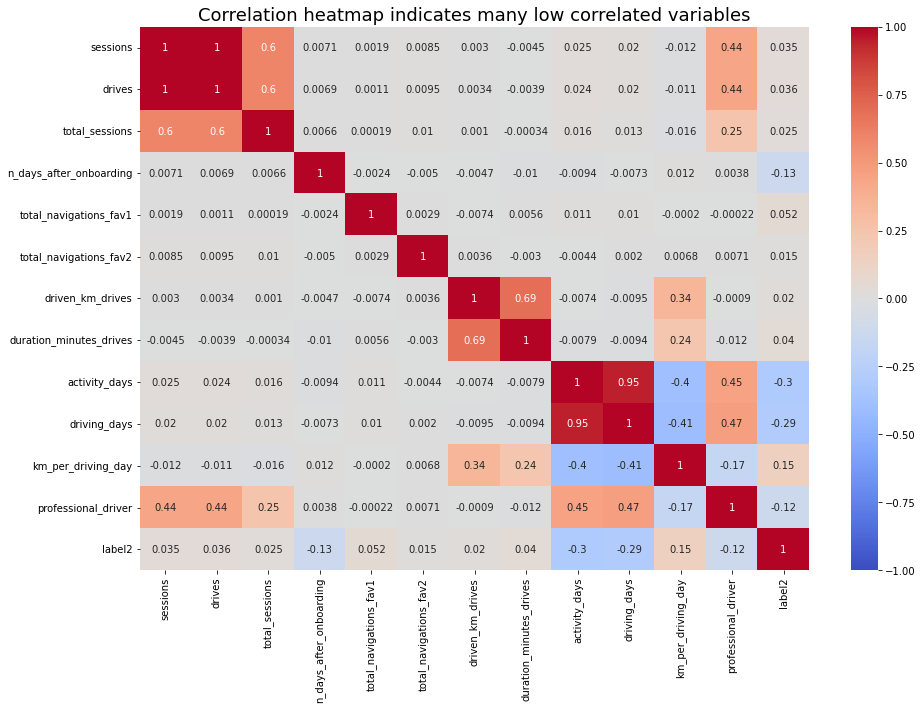

In [ ]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap indicates many low correlated variables', fontsize=18)
plt.show();

The correlation matrix and heatmap highlight strong multicollinearity between `sessions` and `drives` (correlation near 1.0), and between `activity_days` and `driving_days` (correlation around 0.95).

To reduce redundancy, only one variable from each highly correlated pair is retained in the final feature set. 

### **Encoding device type**

The `device` variable is binary-encoded as `device2` (0 for Android, ` for iPhone) so it can be used directly as a numeric predictor. 

In [ ]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device','device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


### **Feature set and target**
The feature matrix `x` excludes the original label fields, the unencoded device column, and two highly collinear variables (`session`, `driving_days`) in favor of `drives` and `activity_days`, which show slightly stronger associations with churn. 

In [19]:
# Isolate predictor variables
X = df.drop(columns=['label','label2','device','sessions','driving_days'])

In [20]:
# Isolate target variable
y=df['label2']

#### **Train-test split**

The data is split into training and test sets using stratified sampling on the target to preserve the original churn vs. retention ratio, which helps obtain reliable performance estimates on an imbalanced classification probem. 

In [21]:
# Perform the train-test split, stratify=y preserves class proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
X_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver
152,108,186.192746,3116,243,124,8898.716275,4668.180092,24,612.305861,1
11899,2,3.487590,794,114,18,3286.545691,1780.902733,5,3286.545691,0
10937,139,347.106403,331,4,7,7400.838975,2349.305267,15,616.736581,0
669,108,455.439492,2320,11,4,6566.424830,4558.459870,18,410.401552,1
8406,10,89.475821,2478,135,0,1271.248661,938.711572,27,74.779333,0


A binomial logistic regression model without regularization (`penalty='none'`) is fitted to the training data to estimate the relationship between predictors and the log-odds of churn. 

In [22]:
model = LogisticRegression(penalty=None, max_iter=400)

model.fit(X_train, y_train)

/Users/shreyasj/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/shreyasj/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/shreyasj/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/shreyasj/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/shreyasj/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_point

LogisticRegression(max_iter=400, penalty=None)

### **Model coefficients and intercept**

Model coefficients quantify how each predictor is associated with the log‑odds of churn, holding other variables constant. Positive coefficients increase the log‑odds (and thus the probability) of churn, while negative coefficients decrease it.

In [ ]:
# coefficients with respective feature names
pd.Series(model.coef_[0], index=X.columns)

drives                     0.001955
total_sessions             0.000362
n_days_after_onboarding   -0.000399
total_navigations_fav1     0.001257
total_navigations_fav2     0.001016
driven_km_drives          -0.000008
duration_minutes_drives    0.000110
activity_days             -0.106213
professional_driver       -0.009830
device2                    0.017354
dtype: float64

In [ ]:
# intercept value
model.intercept_

array([-0.00170675])

Larger magnitude coefficients indicate features with stronger influence on the predicted log‑odds of churn, although statistical significance is not directly assessed in this scikit‑learn implementation.


#### **Logit linearity check**

To assess the assumption of approximate linearity between continuous predictors and the log‑odds of churn, predicted probabilities on the training data are transformed to logits and plotted against a key predictor.


In [27]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.93963483, 0.06036517],
       [0.61967304, 0.38032696],
       [0.76463181, 0.23536819],
       ...,
       [0.91909641, 0.08090359],
       [0.85092112, 0.14907888],
       [0.93516293, 0.06483707]])

In [ ]:
# Copy the training predictors and add the logit of chrun probability
logit_data = X_train.copy()
logit_data['logit'] = [np.log(prob[1]/prob[0]) for prob in training_probabilities]

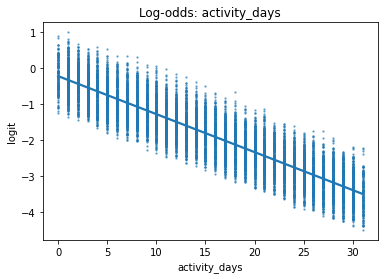

In [ ]:
# Plot regplot of `activity_days` vs log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

The regplot for `activity_days` suggests an approximately monotonic, near‑linear relationship between activity and the log‑odds of churn, which is reasonably consistent with the logistic regression linearity assumption for this predictor.


## **Model evaluation**

### **Classification performance**

Predictions are generated on the held‑out test set, and standard classification metrics are used to assess how well the model identifies churned users versus retained users.


In [24]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

/Users/shreyasj/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/shreyasj/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/shreyasj/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [25]:
# accuracy on the test data
model.score(X_test,y_test)

/Users/shreyasj/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/shreyasj/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/shreyasj/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


0.8237762237762237

Accuracy provides an overall proportion of correct predictions but can be misleading when classes are imbalanced, so additional metrics are examined.


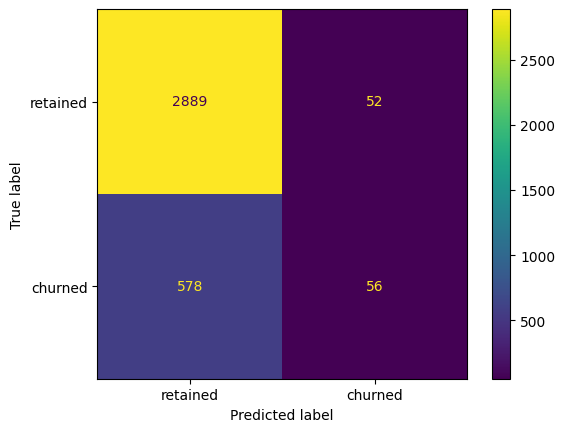

In [26]:
# confusion matrix display
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained','churned'])
disp.plot();

In [27]:
# Calculate precision and recall manually
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])
recall = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision, recall

(np.float64(0.5185185185185185), np.float64(0.08832807570977919))

In [29]:
# Full classification report
target_labels = ['retained', 'churned']
print(classification_report(y_test,y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.52      0.09      0.15       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



The model achieves decent precision but relatively low recall for the churn class, indicating that it misses a substantial number of true churners (false negatives). For churn mitigation, this means many at‑risk users would not be flagged by the model.


### **Feature importance (coefficients)**

To visualize which features most strongly influence the model’s predictions, standardized coefficients are sorted and plotted.


In [28]:
# Create a list of (feature, coefficient) tuples
feature_importance = list(zip(X_train.columns, model.coef_[0]))

feature_importance = sorted(feature_importance, key=lambda x:x[1], reverse = True)
feature_importance

[('drives', np.float64(0.0019386997449150638)),
 ('total_navigations_fav1', np.float64(0.0012576123846057485)),
 ('total_navigations_fav2', np.float64(0.0010081264365241322)),
 ('total_sessions', np.float64(0.00036972557134233466)),
 ('duration_minutes_drives', np.float64(0.00011027064532815716)),
 ('km_per_driving_day', np.float64(1.9605797999460165e-05)),
 ('driven_km_drives', np.float64(-1.25018314094188e-05)),
 ('n_days_after_onboarding', np.float64(-0.00040006982606242367)),
 ('professional_driver', np.float64(-0.006791661419025915)),
 ('activity_days', np.float64(-0.10518437371473649))]

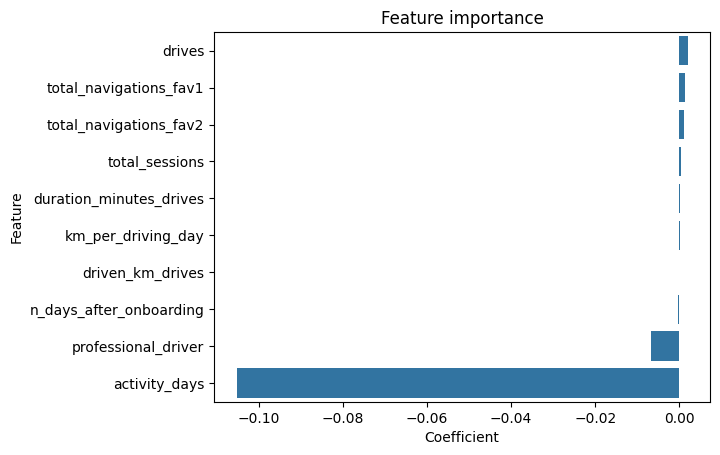

In [34]:
# Plot the feature importances
sns.barplot(x = [x[1] for x in feature_importance],
           y = [x[0] for x in feature_importance],
           orient = 'h')
plt.title('Feature importance');
plt.xlabel('Coefficient');
plt.ylabel('Feature');

Features with larger positive coefficients are associated with higher churn risk, while those with large negative coefficients are associated with retention, holding other variables constant.


## **Model insights and business implications**

- `activity_days` is by far the most influential variable in the model’s prediction, with higher activity strongly associated with retention and lower churn probability. This aligns with earlier EDA showing that more active users tend to stay on the platform.  
- In prior EDA, churn increased as `km_per_driving_day` rose, and the correlation heatmap indicated a strong positive association with churn. In the multivariate logistic model, however, this feature becomes relatively weak, suggesting that its apparent effect is largely explained by other, more informative usage variables.

In a multiple logistic regression model, predictors can interact and share variance, which can make some features look less important once others are included. This can improve predictive performance while making interpretation less intuitive.

From a business perspective, the current model’s low recall on churners limits its usefulness for high‑stakes retention campaigns, where missing at‑risk users is costly. It is more suitable as a baseline model to guide further feature engineering and model experimentation rather than as a deployment‑ready churn predictor.

Potential improvements include:
- Engineering additional behavioral and temporal features (for example, recent changes in usage, patterns of cancellation, or route diversity) to capture early signs of disengagement.  
- Exploring alternative model specifications (feature subsets, regularization, and class‑weighting) and comparing against more flexible machine learning models in the subsequent notebook.

Additional data such as drive‑level details (route characteristics, duration, time of day) and richer in‑app interaction signals (reports, confirmations, search behavior) would likely improve both predictive power and actionability for churn prevention strategies.
